In [3]:
#%config IPCompleter.use_jedi=False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


from pandas._libs.tslibs.timestamps import Timestamp
from pandas.core.frame import DataFrame
from pandas.core.series import Series
from matplotlib.axes._axes import Axes
from numpy import ndarray

sys.path.append('..')
from cyclingEfficiency import CyclingEfficiency, Visualize

Como en el anterior notebook se vio que realmente existe una diferencia en la eficiencia dependiendo del terreno, el objetivo ahora es encontrar el mejor modelo para cada uno de los escenarios. Para estos casos se utilizarán el modelo de regresión lineal y bosques aleatorios. Para hacer todo el proceso más sencillo, se ha condensado toda la manipulación de datos hecha anteriormente en la clase "CyclingEfficiency" con el fin de hacer más sencillo el trabajo de pruebas. 

In [53]:
cad_step: int = 5

cyclingEfficiency: CyclingEfficiency = CyclingEfficiency(
    hr_max=190,
    bike_weight=11,
    cad_min=55,
    cad_max=100,
    cad_step=cad_step,
)

/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1452/249129148.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph

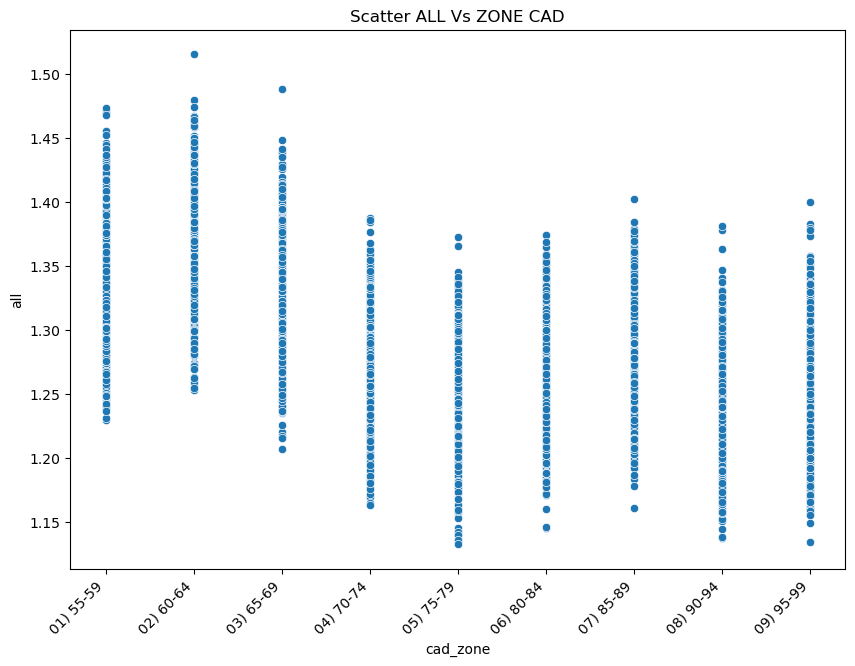

/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1452/249129148.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph

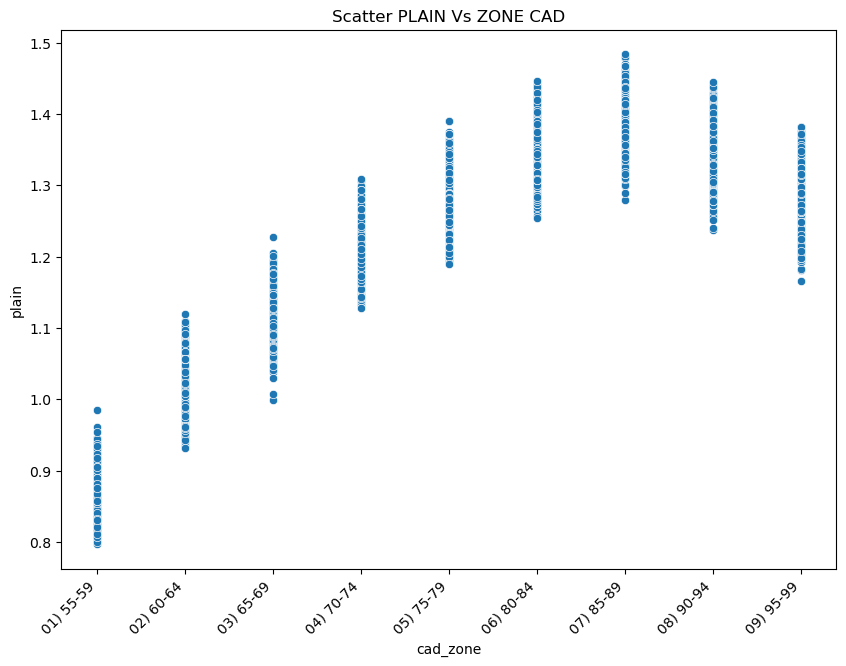

/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1452/249129148.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph

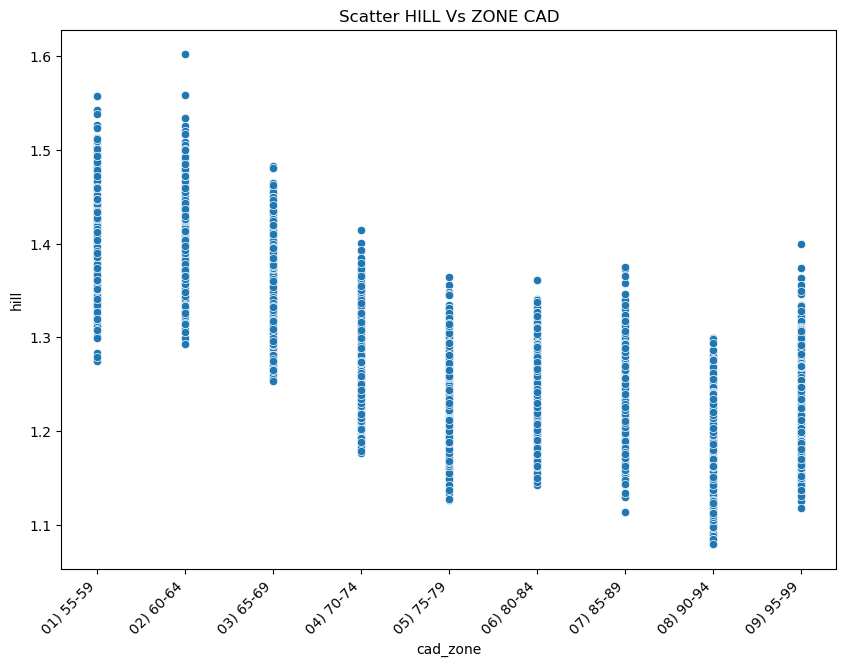

In [35]:
columns = ['all', 'plain', 'hill']
for variable in columns:
    plt.figure(figsize=(10, 7))
    graph = sns.scatterplot(
        data=cyclingEfficiency.samples,
        x='cad_zone',
        y=variable
    )
    graph.set_xticklabels(
        graph.get_xticklabels(), rotation=45,
        horizontalalignment='right'
    )

    plt.title('Scatter {} Vs ZONE CAD'.format(variable.upper()))
    plt.show()

In [36]:
cyclingEfficiency.samples['cad_zone_num_2'] = cyclingEfficiency.samples['cad_zone_num'] ** 2
cyclingEfficiency.samples['cad_zone_num_3'] = cyclingEfficiency.samples['cad_zone_num'] ** 3

In [37]:
def graph_model(
    data: DataFrame, X: DataFrame, y_pred: Series, variable: str, 
    cad_zone: ndarray 
):
    cad_zone.sort()

    plt.figure(figsize=(10, 7))
    graph = sns.scatterplot(
        data=data,
        x='cad_zone_num',
        y=variable,
        label='y_test',
        color='#3333CC'
    )

    graph.set_xticks(
        range(1, len(cad_zone) + 1),
        cad_zone
    )

    graph.set_xticklabels(
        graph.get_xticklabels(), rotation=45,
        horizontalalignment='right'
    )
        
    graph = plt.plot(
        X['cad_zone_num'],
        y_pred,
        label='y_pred',
        color='#CC3333'
    )

    plt.legend()
    plt.title('Scatter {} Vs ZONE CAD'.format(variable.upper()))
    plt.show()

## Model Plain

In [38]:
variable: str = 'plain'
x_variables: list[str] = [
    'cad_zone_num', 'cad_zone_num_2',
]
formula_x = ' + '.join(x_variables)

x_train, x_test, y_train, y_test = train_test_split(
    cyclingEfficiency.samples[x_variables],
    cyclingEfficiency.samples[variable],
)

data_train: DataFrame = pd.concat([x_train, y_train],axis=1)
data_test: DataFrame = pd.concat([x_test, y_test],axis=1)

model_plain = (
    smf.ols(
        formula=variable + ' ~ ' + formula_x,
        data=data_train
    ).fit()
)

max_value: int = data_train['cad_zone_num'].max()
x: list[int] = [
    (i + 1, (i + 1)**2,) for i in range(max_value)
]

X: DataFrame = pd.DataFrame(
    x,
    columns=x_variables
)

y_pred_plain: ndarray = model_plain.predict(X)

model_plain.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  plain   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 6.990e+04
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:02:27   Log-Likelihood:                 13006.
No. Observations:                6750   AIC:                        -2.601e+04
Df Residuals:                    6747   BIC:                        -2.599e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.6919      0.002    423.327      0.000       0.689       0.695
cad_zone_num       0.1883      0.001    250.713      0.000       0.187       0.190
cad_zone_num_2    -0.0134   7.33e-05   -183.091      0.000      -0.014      -0.013
==============================================================================
Omnibus:                        2.254   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                2.256
Skew:                           0.045   Prob(JB):                        0.324
Kurtosis:                       2.996   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
print('Model plain',r2_score(y_test, model_plain.predict(x_test)))

Model plain 0.9549692531411296


/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


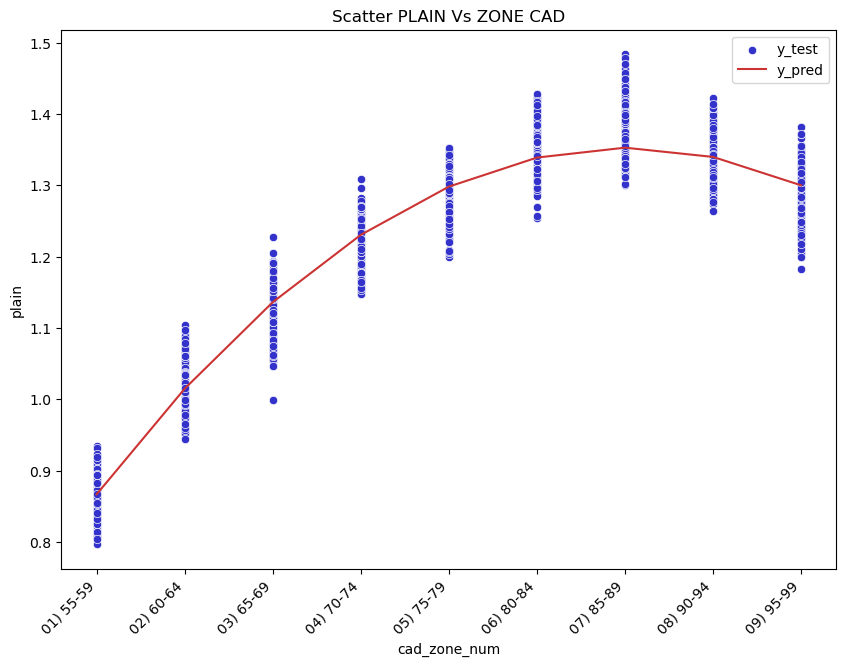

In [40]:
graph_model(
    data_test, X, y_pred_plain, variable, cyclingEfficiency.cad_zones
)

## Model Hill

In [41]:
variable: str = 'hill'
x_variables: list[str] = [
    'cad_zone_num', 'cad_zone_num_2',
    'cad_zone_num_3', 
]
formula_x = ' + '.join(x_variables)

x_train, x_test, y_train, y_test = train_test_split(
    cyclingEfficiency.samples[x_variables],
    cyclingEfficiency.samples[variable],
)

data_train: DataFrame = pd.concat([x_train, y_train], axis=1)
data_test: DataFrame = pd.concat([x_test, y_test], axis=1)

model_hill = (
    smf.ols(
        formula= variable + ' ~ ' + formula_x,
        data=data_train
    ).fit()
)

max_value: int = cyclingEfficiency.samples['cad_zone_num'].max()
x: list[int] = [
    (i + 1, (i + 1)**2, (i + 1)**3,) 
    for i in range(max_value)
]

X: DataFrame = pd.DataFrame(
    x,
    columns=x_variables
)

y_pred_hill: ndarray = model_hill.predict(X)

model_hill.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hill   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     7261.
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:02:27   Log-Likelihood:                 11646.
No. Observations:                6750   AIC:                        -2.328e+04
Df Residuals:                    6746   BIC:                        -2.326e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4387      0.003    424.113      0.000       1.432       1.445
cad_zone_num      -0.0101      0.003     -3.635      0.000      -0.016      -0.005
cad_zone_num_2    -0.0098      0.001    -15.606      0.000      -0.011      -0.009
cad_zone_num_3     0.0009   4.16e-05     22.280      0.000       0.001       0.001
==============================================================================
Omnibus:                       36.321   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.832
Skew:                           0.175   Prob(JB):                     1.00e-08
Kurtosis:                       3.095   Cond. No.                     2.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


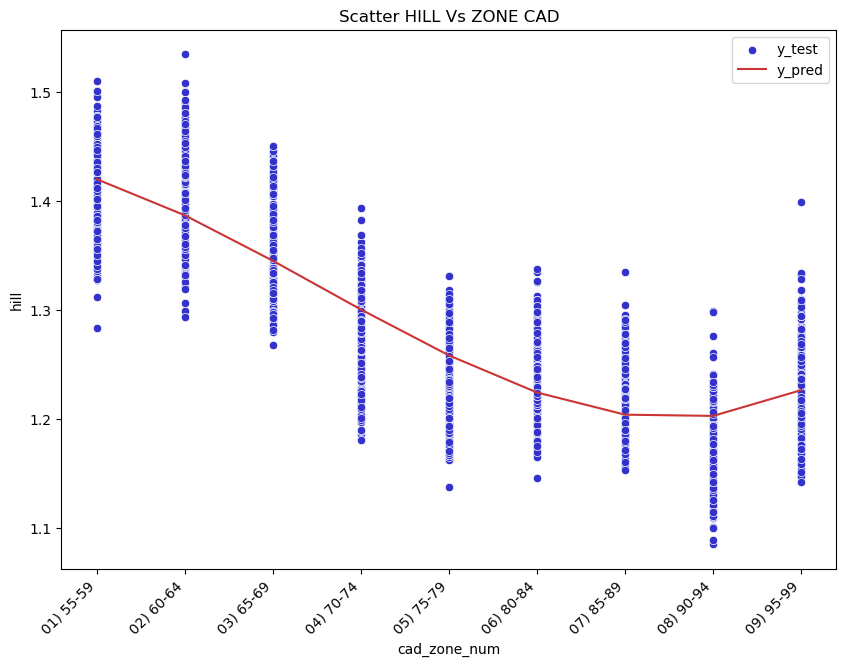

In [42]:
graph_model(
    data_test, X, y_pred_plain, variable, cyclingEfficiency.cad_zones
)

In [43]:
x_variables_model_2: list[str] = [
    'cad_zone_num', 
]

x_train_model_2, x_test_model_2, y_train_model_2, y_test_model_2 = train_test_split(
    cyclingEfficiency.samples[x_variables_model_2],
    cyclingEfficiency.samples[variable],
)

data_train_model_2: DataFrame = pd.concat([x_train_model_2, y_train_model_2], axis=1)
data_test_model_2: DataFrame = pd.concat([x_test_model_2, y_test_model_2], axis=1)

x: list[int] = [
    (i + 1, ) 
    for i in range(max_value)
]

X_model_2: DataFrame = pd.DataFrame(
    x,
    columns=x_variables_model_2
)

model_hill_2 = RandomForestRegressor(n_estimators=1000, max_depth=4)
model_hill_2.fit(x_train_model_2, y_train_model_2)

y_pred_hill_2: ndarray = model_hill_2.predict(X_model_2)

/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


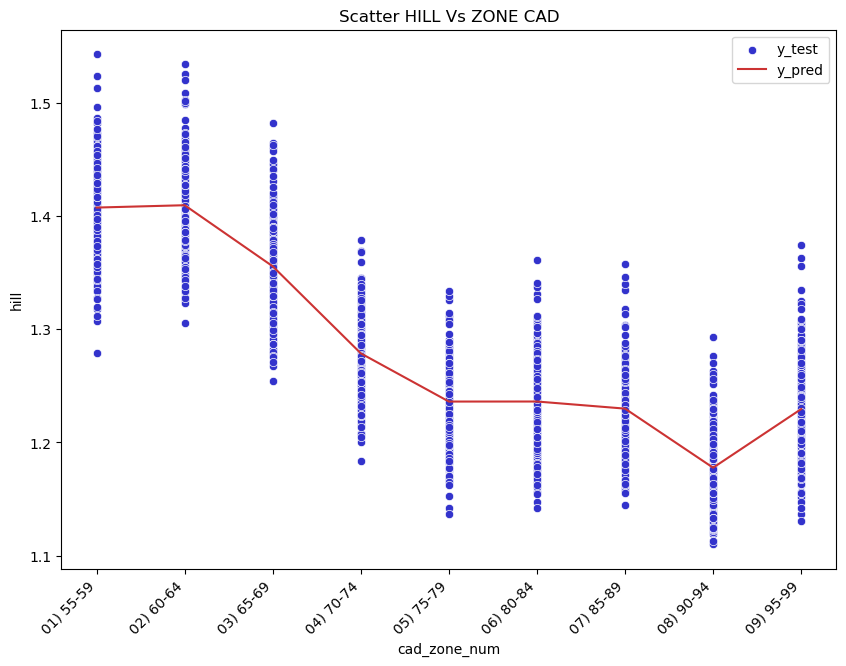

In [44]:
graph_model(
    data_test_model_2, X_model_2, y_pred_hill_2, 
    variable, cyclingEfficiency.cad_zones
)

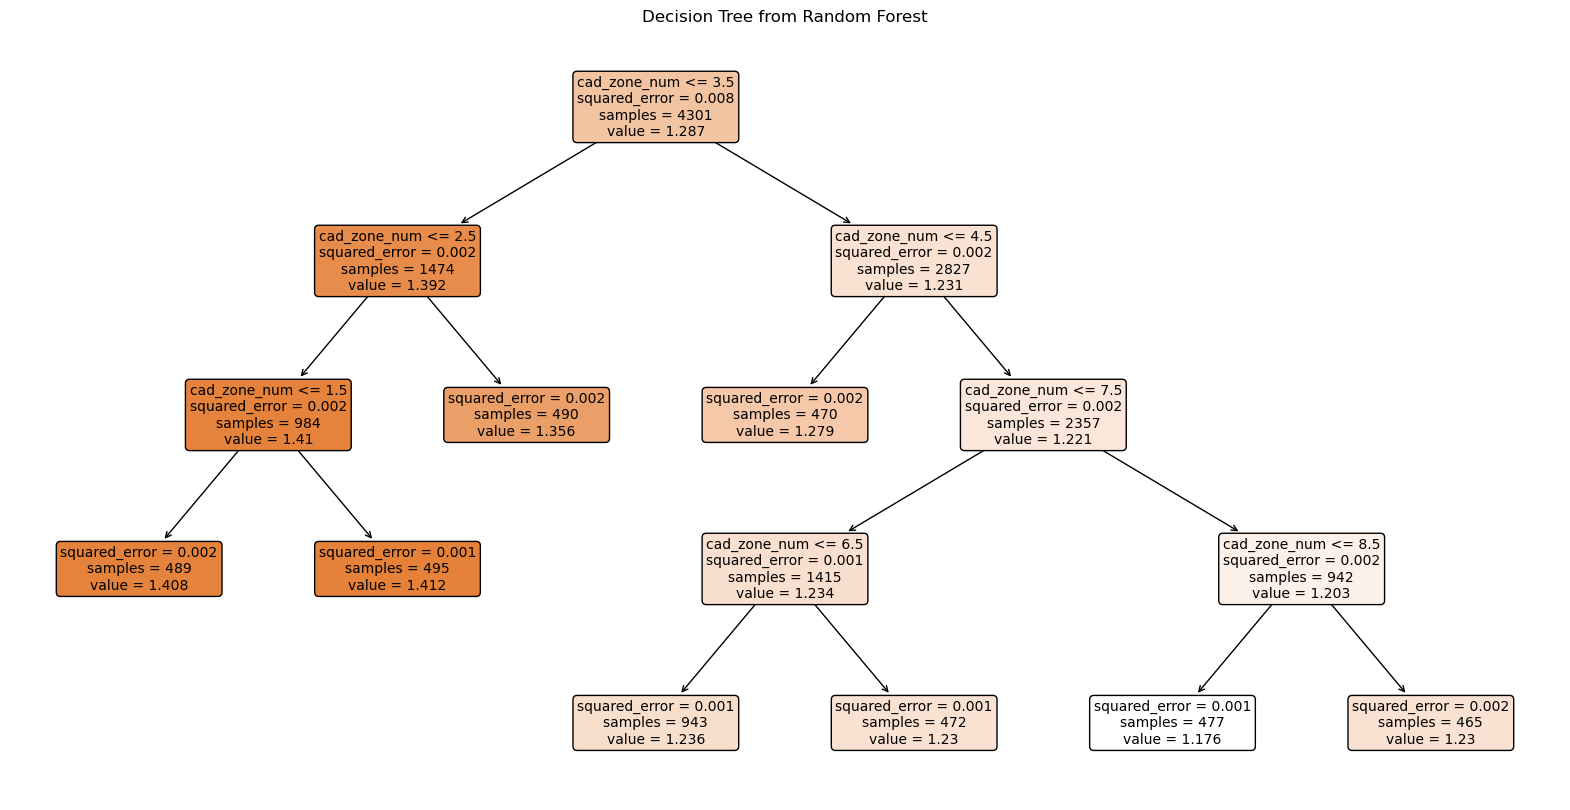

In [45]:
from sklearn.tree import plot_tree
model_hill_2.estimators_[0]

tree_to_plot = model_hill_2.estimators_[0]
 
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=data_test.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

In [46]:
print('Model 1',r2_score(y_test, model_hill.predict(x_test)))
print('Model 2',r2_score(y_test_model_2, model_hill_2.predict(x_test_model_2)))

Model 1 0.7691852127739034
Model 2 0.8046769910478397


# Conclusiones

In [66]:
margen_value: float = 0.05

In [55]:
# Plain
cad_zone_max_name_plain: str = cyclingEfficiency.cad_zones[
            np.argmax(y_pred_plain)
        ]
cad_zone_max_plain: int = np.max(y_pred_plain)

print(
    '''El rango de cadencia mas eficiente en el terreno plano es {}
    y puede generar un promedio de eficiencia de {:.4f}'''.format(
        cad_zone_max_name_plain[4:],
        cad_zone_max_plain,
))

El rango de cadencia mas eficiente en el terreno plano es 85-89
    y puede generar un promedio de eficiencia de 1.3527


In [79]:
cyclingEfficiency.data[
    (cyclingEfficiency.data['is_plain'] == 1) &
    (cyclingEfficiency.data['cad_zone'] == cad_zone_max_name_plain) &
    (cyclingEfficiency.data['performance_indicator'] > (cad_zone_max_plain * (1 - margen_value))) &
    (cyclingEfficiency.data['performance_indicator'] < (cad_zone_max_plain * (1 + margen_value)))
].sample(10)


,secs,cad,hr,km,kph,watts,alt,lon,lat,slope,...,weight,zones,is_plain,w,w_hr,w_kg,w_kg_hr,performance_indicator,cad_zone,cad_zone_num
220615,5381,85.0,150.0,37.2745,34.7904,0.0,2570.2,-74.183287,4.779226,0.395576,...,62.7,2,1,167.209088,1.114727,2.666812,0.017779,1.333406,07) 85-89,7
24110,3740,88.0,137.0,25.4988,33.2712,0.0,2598.0,-74.216637,4.830002,0.479059,...,64.6,2,1,169.746073,1.239022,2.627648,0.019180,1.313824,07) 85-89,7
128364,3795,89.0,128.0,18.9136,28.7352,0.0,2631.2,-74.179382,4.892970,0.991956,...,64.6,2,1,176.932541,1.382285,2.738894,0.021398,1.369447,07) 85-89,7
236352,1155,86.0,105.0,5.6614,21.2400,53.0,2547.0,0.000000,0.000000,0.000000,...,70.6,1,1,94.362240,0.898688,1.336576,0.012729,1.336576,07) 85-89,7
215728,5727,85.0,138.0,38.5418,33.2820,0.0,2578.8,-74.191654,4.785508,0.428571,...,64.0,2,1,165.022953,1.195819,2.578484,0.018685,1.289242,07) 85-89,7
240950,2777,88.0,137.0,13.7015,30.2472,0.0,2607.6,-74.258983,4.840443,0.873016,...,62.7,2,1,174.344904,1.272591,2.780620,0.020296,1.390310,07) 85-89,7
133282,13894,89.0,146.0,67.3399,33.2784,0.0,2611.0,-74.246554,4.831711,0.619048,...,64.6,2,1,179.369790,1.228560,2.776622,0.019018,1.388311,07) 85-89,7
192636,4086,85.0,124.0,13.8927,32.7564,0.0,2589.0,-74.107455,4.660227,0.582011,...,62.2,2,1,168.533893,1.359144,2.709548,0.021851,1.354774,07) 85-89,7
25993,6529,88.0,146.0,44.7527,28.7280,0.0,2705.6,-74.147357,4.971804,0.857143,...,64.6,2,1,168.918787,1.156978,2.614842,0.017910,1.307421,07) 85-89,7
22872,1387,87.0,135.0,8.2463,33.2856,0.0,2598.2,-74.219689,4.812836,0.619048,...,64.6,2,1,179.408598,1.328953,2.777223,0.020572,1.388611,07) 85-89,7


In [57]:
# Hill
cad_zone_max_name_hill: str = cyclingEfficiency.cad_zones[
            np.argmax(y_pred_hill_2)
        ]
cad_zone_max_hill: int = np.max(y_pred_hill_2)
print(
    '''El rango de cadencia mas eficiente en montaña es {}
    y puede generar un promedio de eficiencia de {:.4f}'''.format(
        cad_zone_max_name_hill[4:],
        cad_zone_max_hill,
))

El rango de cadencia mas eficiente en montaña es 60-64
    y puede generar un promedio de eficiencia de 1.4096


In [81]:
cyclingEfficiency.data[
    (cyclingEfficiency.data['is_plain'] == 0) &
    (cyclingEfficiency.data['cad_zone'] == cad_zone_max_name_hill) &
    (cyclingEfficiency.data['performance_indicator'] > (cad_zone_max_hill * (1 - margen_value))) &
    (cyclingEfficiency.data['performance_indicator'] < (cad_zone_max_hill * (1 + margen_value)))
].sample(10)

,secs,cad,hr,km,kph,watts,alt,lon,lat,slope,...,weight,zones,is_plain,w,w_hr,w_kg,w_kg_hr,performance_indicator,cad_zone,cad_zone_num
538942,4028,64.0,154.0,19.1518,15.1200,0.0,957.2,-74.367756,5.032720,6.82540,...,66.9,3,0,282.466461,1.834198,4.222219,0.027417,1.407406,02) 60-64,2
352643,3710,60.0,168.0,21.7559,21.1680,0.0,2637.8,-74.176031,4.913939,6.46032,...,66.9,4,0,379.172841,2.256981,5.667755,0.033737,1.416939,02) 60-64,2
333964,67,60.0,98.0,0.2226,6.0480,0.0,832.4,-74.463112,5.031859,5.23810,...,64.0,1,0,89.287507,0.911097,1.395117,0.014236,1.395117,02) 60-64,2
85241,9285,60.0,131.0,22.9862,7.5600,0.0,1337.4,-75.022993,5.164415,10.00000,...,66.9,2,0,191.586211,1.462490,2.863770,0.021861,1.431885,02) 60-64,2
14138,4354,64.0,150.0,11.7282,9.0720,0.0,1375.2,-74.327880,4.988695,8.09524,...,66.9,2,0,193.706282,1.291375,2.895460,0.019303,1.447730,02) 60-64,2
86098,10825,63.0,130.0,26.0649,9.0720,0.0,1451.2,-75.037524,5.150298,7.61905,...,66.9,2,0,184.629459,1.420227,2.759783,0.021229,1.379891,02) 60-64,2
199764,4480,63.0,130.0,22.6094,24.1992,0.0,2519.2,-73.118182,5.757403,1.82540,...,63.5,2,0,187.725466,1.444042,2.956307,0.022741,1.478153,02) 60-64,2
287663,23446,64.0,138.0,104.7670,25.7292,0.0,2568.2,-72.823029,6.010746,1.30556,...,63.5,2,0,172.479132,1.249849,2.716207,0.019683,1.358103,02) 60-64,2
389794,10338,63.0,147.0,42.8244,9.0720,0.0,1780.4,-74.313925,4.971796,7.27897,...,62.3,2,0,167.621787,1.140284,2.690558,0.018303,1.345279,02) 60-64,2
280923,9291,64.0,144.0,32.2908,13.6080,0.0,2764.8,-72.978469,5.890392,4.76190,...,63.5,2,0,186.464682,1.294894,2.936452,0.020392,1.468226,02) 60-64,2


En resumen, si existe diferencia entre el terreno llano y el terreno con desnivel, para cada uno existe una cadencia óptima diferente. Esos puntos indican que en ese nivel de cadencia respectivo se puede llegar a generar el esfuerzo mayor con el menor desgaste posible.

Para futuros análisis, se podría validar si, dependiendo del grado de pendiente, puede cambiar el resultado, además de validar si con los datos de otros ciclistas los valores cambian o se mantienen. 

In [5]:
from cyclingEfficiency import Model
model = Model(
    hr_max=190,  bike_weight=11,
    cad_min=55,
    cad_max=100,
    cad_step=5,
)

El rango de cadencia promedio mas eficiente en montaña es 60-64 y puede generar un promedio de eficiencia de 1.4096


/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


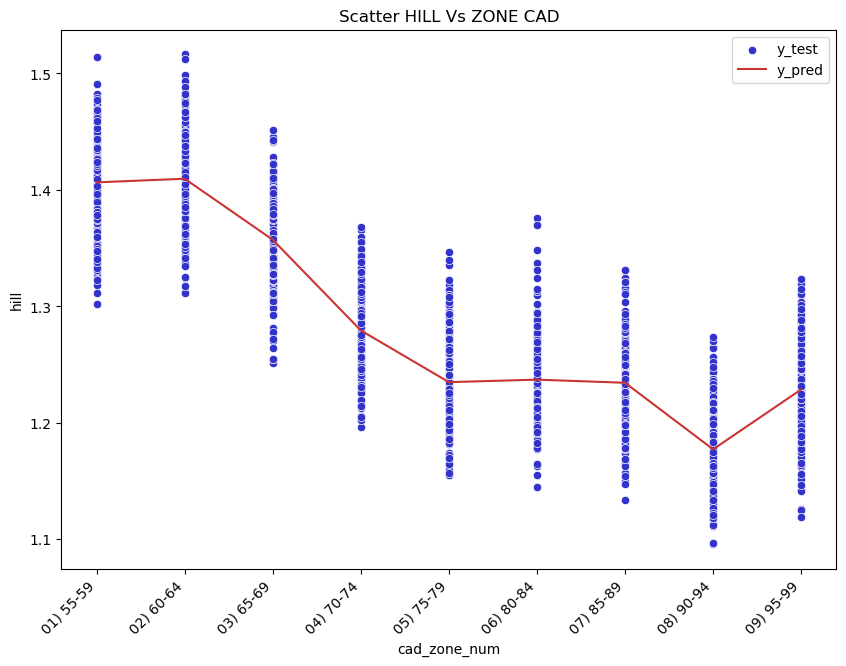

In [6]:
model.fit_hill()
Visualize.graph_model(
    model.data_test_hill, 
    model.X_hill, 
    model.y_pred_hill, 
    'hill', 
    model.cyclingEfficiency.cad_zones
)


El rango de cadencia promedio mas eficiente en llano es 85-89 y puede generar un promedio de eficiencia de 1.3526


/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jaor/Programs/anaconda3/envs/Machine_Learning/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


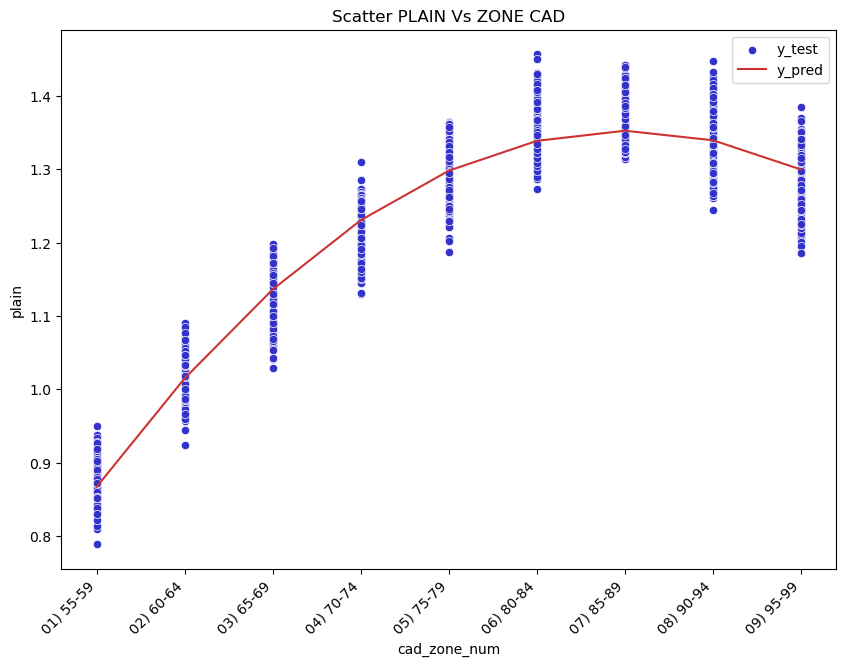

In [7]:
model.fit_plain(2)
Visualize.graph_model(
    model.data_test_plain, 
    model.X_plain, 
    model.y_pred_plain, 
    'plain', 
    model.cyclingEfficiency.cad_zones
)

In [8]:
model.data_hill

,secs,cad,hr,km,kph,watts,alt,lon,lat,slope,...,weight,zones,is_plain,w,w_hr,w_kg,w_kg_hr,performance_indicator,cad_zone,cad_zone_num
2060,5470,63.0,144.0,26.5317,19.6560,0.0,2702.4,-74.149946,4.928833,2.38095,...,62.3,2,0,171.800376,1.193058,2.757630,0.019150,1.378815,02) 60-64,2
3165,8190,60.0,124.0,36.9526,9.0720,0.0,2612.2,-74.102972,4.926919,8.09524,...,62.3,2,0,182.267913,1.469903,2.925649,0.023594,1.462824,02) 60-64,2
3188,8234,64.0,128.0,37.0282,9.0720,0.0,2617.8,-74.102808,4.927515,7.61905,...,62.3,2,0,173.727077,1.357243,2.788557,0.021786,1.394278,02) 60-64,2
5332,15519,64.0,135.0,59.4667,27.2232,0.0,2608.2,-74.195734,4.853929,1.19280,...,62.3,2,0,173.431067,1.284675,2.783805,0.020621,1.391903,02) 60-64,2
6026,17291,60.0,148.0,72.6973,12.0924,0.0,2635.4,-74.275629,4.849305,5.27572,...,62.3,2,0,175.379356,1.184996,2.815078,0.019021,1.407539,02) 60-64,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588976,3673,64.0,133.0,18.3662,20.1420,0.0,895.8,-74.375188,5.044365,2.45908,...,62.0,2,0,178.452199,1.341746,2.878261,0.021641,1.439131,02) 60-64,2
588981,3678,64.0,130.0,18.3965,21.7980,0.0,896.2,-74.375045,5.044220,1.92403,...,62.0,2,0,169.963630,1.307413,2.741349,0.021087,1.370674,02) 60-64,2
589065,3811,62.0,117.0,19.0765,11.3688,0.0,904.6,-74.371918,5.039317,2.03740,...,62.0,1,0,91.204731,0.779528,1.471044,0.012573,1.471044,02) 60-64,2
589650,4988,63.0,139.0,27.1143,17.8596,0.0,859.8,-74.425443,5.065404,2.92816,...,62.0,2,0,174.860773,1.257991,2.820335,0.020290,1.410168,02) 60-64,2
